# Summer 2023 Multiple EM27s in Salt Lake City

## Import and declare functions, Define paths

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import matplotlib
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None

In [2]:
#Declare functions
def plot_reg_on_ax(ax,reg_details,labsize = 10,color = 'grey',slope_permil=False,yint_permil = False):
    '''Plots a regression line and its details on a matplotlib ax and legend
    
    Args:
    ax (axis from plt): a plt ax object on which to plot
    reg_details (dict) : details of the regression, generated by lin_regress_2()
    labsize (int) : size of the label for the legend
    
    Returns:
    ax : plt ax object with the regression line and legend plotted
    '''
    r2_val = reg_details['r2']
    if slope_permil:
        slope_val = reg_details['slope']*1000 #get the "per mille" value by multiplying by 1000
    else:
        slope_val = reg_details['slope']
    if yint_permil:
        yint_val = reg_details['yint']*1000
    else:
        yint_val = reg_details['yint']
                               
    annotation = f"R2={r2_val:.2}\n"
    annotation += f"slope={slope_val:.5}"
    if slope_permil:
        annotation +=  "$^o/_{oo}$"
    annotation += '\n'
    annotation += f"y_int={yint_val:.3}"
    if yint_permil:
        annotation +=  "$^o/_{oo}$"

    ax.plot(reg_details['x_regr_line'],reg_details['y_regr_line'],label = annotation,c = color)
    leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,fontsize = labsize)
    for item in leg.legend_handles:
        item.set_visible(False)
    return ax

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def make_daily_ts_plot(sub_oof_dfs,wbb_met_single,ts_met_single,plot_specs,before_hours,after_hours,windmode,resample,ha_color='deepskyblue',ua_color='tomato',
                    savefullpath = False,show=False):
    fig,axes = plt.subplots(len(plot_specs)+1,1,figsize = (15,7.5),height_ratios=[2,2,2,1.5])
    labsize = 14
    markersize = 3
    xlim0_list = []
    xlim1_list = []
    for inst_id in sub_oof_dfs.keys():
        xlim0_list.append(sub_oof_dfs[inst_id].index[0])
        xlim1_list.append(sub_oof_dfs[inst_id].index[-1])
    xlims = [min(xlim0_list)-datetime.timedelta(hours=before_hours),max(xlim1_list)+datetime.timedelta(hours=after_hours)]
    row = 0
    for plot_spec in plot_specs:
        for inst_id in sub_oof_dfs.keys():
            if inst_id == 'ha':
                scatter_color = ha_color
            else:
                scatter_color = ua_color
            plotdf = sub_oof_dfs[inst_id]
            axes[row].scatter(plotdf.index,plotdf[plot_spec],color = scatter_color,zorder=3,label=f'{inst_id} resample {resample}',s=markersize)
            axes[row].errorbar(plotdf.index,plotdf[plot_spec],
                            yerr=plotdf[f"{plot_spec.split('_')[-1]}_error"],ls='none',
                            ecolor='grey',alpha=0.2)
        axes[row].tick_params(labelsize = labsize)
        axes[row].set_ylabel(plot_spec.split('_')[-1],size = labsize)
        axes[row].set_xlim(xlims)
        axes[row].xaxis.grid(True)
        if row == 0:
            axes[row].legend(fontsize = labsize *0.8,loc = 'upper right')
        row+=1
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %Z', tz = plotdf.index[0].tz))
    axes[-1].set_xlabel(sub_oof_dfs['ha'].index[0].strftime('%b %d, %Y'),size = labsize)
    cmap = matplotlib.colormaps['Blues']
    new_cmap = truncate_colormap(cmap, 0.3, 1)
    axes[3].barbs(wbb_met_single[::windmode].index,5,wbb_met_single['u'][::windmode],wbb_met_single['v'][::windmode],
                    wbb_met_single['ws'][::windmode],cmap = new_cmap,length =6,barb_increments={'half':3,'full':5,'flag':10})
    if len(ts_met_single)>0:
        cmap = matplotlib.colormaps['Reds']
        new_cmap = truncate_colormap(cmap, 0.3, 1)
        axes[3].barbs(ts_met_single[::windmode].index,-5,ts_met_single['u'][::windmode],ts_met_single['v'][::windmode],
                        ts_met_single['ws'][::windmode],cmap = new_cmap,length = 6,barb_increments={'half':3,'full':5,'flag':10})

    axes[3].tick_params(labelsize = labsize)
    axes[3].set_ylabel('wind barbs',size = labsize)
    axes[3].get_yaxis().set_ticklabels([])
    axes[3].set_xlim(xlims)
    axes[3].set_ylim(-9,9)
    if (sub_oof_dfs['ha'].index[0]<pd.to_datetime('2023-07-12 00:00:00').tz_localize('US/Mountain')) | (sub_oof_dfs['ha'].index[0]>pd.to_datetime('2023-08-12 00:00:00').tz_localize('US/Mountain')):
        title = 'Side By Side WBB' 
    else:
        title = 'Upwind Downwind WBB/DBK'
    axes[0].set_title(title)
    plt.subplots_adjust(hspace=0.1)
    plt.gcf().autofmt_xdate()
    if show:
        plt.show()
    if savefullpath is not False:
        fig.savefig(savefullpath,dpi=500)
    plt.close()
    return 

In [3]:
#Define paths
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
em27_data_dir = os.path.join(base_project_dir,'Data/EM27_oof/summer_2023/elaine_retrievals')
figures_dir = os.path.join(base_project_dir,'Data/Summer_2023_ua_ha_EM27/Figures')
out_data_dir = os.path.join(base_project_dir,'Data/Summer_2023_ua_ha_EM27/Data')

## Plot a Map

In [4]:
inst_locs = {'WBB':{'lat':40.766,'lon':-111.847,'masl':1470,'color':'blue'},
             'DBK':{'lat':40.538,'lon':-112.07,'masl':1580,'color':'red'}}

labsize = 14
zoom = .3
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom


extent=[-112.3,-111.5,40.3,41.0]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent(extent,crs=proj)
ax.add_image(request,int(scale))
for inst_loc,details in inst_locs.items():
    axlabel = f"{inst_loc}: {details['lat']},{details['lon']}, {details['masl']}masl"
    ax.scatter(details['lon'],details['lat'],s=200,color=details['color'],label = axlabel)
ax.legend(fontsize = 12)
fig.savefig(os.path.join(figures_dir,'map_inst_locations.png'),dpi=1000)
plt.close()

## Get correction factors for Side By Side

In [5]:
#Define parameters
inst_ids = ['ha','ua']
resample = '1min'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']

In [6]:
#Define and create dataframe for the periods where EM27s were side by side, to get correction

#These are the periods when the two em27's were side by side. 
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {} #initialize the oof managers dictionary
sbs_oof_dfs = {} #initialize the oof dataframe dictionary
for inst_id in inst_ids: #loop through the instruments
    sbs_oof_dfs[inst_id] = pd.DataFrame() #initialize the instrument's dataframe
    for dt_str_range in dt_str_ranges: #loop through the datetime ranges to append the correct subset of values
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone) #set the start datetime
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone) #set the end datetime
        data_folder = os.path.join(em27_data_dir,inst_id) #set the data folder for that instrument
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone) #create the oof manager class to load
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=True,cols_to_load = specs) #load the dataframe in the range, filter on good values
        if resample is not None: #if we want to resample
            df = df.resample(resample).mean(numeric_only = True) #do so
        sbs_oof_dfs[inst_id] = pd.concat([sbs_oof_dfs[inst_id],df]) #add the rows to the instrument's oof df
merged_df = ac.merge_oofdfs(sbs_oof_dfs,dropna=True) #merge the oof dfs and drop na values (not needed in regression)

# Do regressions for each species to use to correct instruments that were side by side
sbs_regressions = {}
for spec in specs:
    x_spec = f'{spec}_ua'
    y_spec = f'{spec}_ha'
    regression = ac.lin_regress_2(merged_df,x_spec,y_spec)
    sbs_regressions[spec] = regression

# Correct ua data to ha data using the regressions
for spec in specs:
    merged_df[f'corr_{spec}_ha'] = merged_df[f'{spec}_ha']
    merged_df[f'corr_{spec}_ua'] = merged_df.apply(lambda row: row[f'{spec}_ua']*sbs_regressions[spec]['slope']+sbs_regressions[spec]['yint'] ,axis = 1)

### Plotting side by side data

In [7]:
#Plot side by side data before the correcion, with the regression subplots to the right. 

show = False
dates = sorted(list(set(merged_df.index.date)))
broken_dtranges = []
for date in dates:
    dtstart_str = f'{date} 08:00:00'
    dtend_str = f'{date} 21:00:00'
    broken_dtranges.append([pd.to_datetime(dtstart_str).tz_localize('US/Mountain'),pd.to_datetime(dtend_str).tz_localize('US/Mountain')])

fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(len(specs),8,width_ratios=[.8,.8,.8,.8,.8,.8,.2,1])
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
gridalpha = 0.2
labelsize = 12
d = .01 # how big to make the diagonal lines in axes coordinates
for row in range(len(specs)):
    spec = specs[row]
    for col in range(len(broken_dtranges)):
        ax = plt.subplot(gs[row,col])
        ax.scatter(merged_df.index,merged_df[f'{spec}_ha'],color =ha_color,s = em27_marker_size)
        ax.scatter(merged_df.index,merged_df[f'{spec}_ua'],color =ua_color,s = em27_marker_size)
        if col == 0:
            alpha = 0.8
        else:
            alpha = 1
        ax.set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
        if col<len(broken_dtranges)-1:
            if col != 3:
                ax.spines['right'].set_visible(False)
            ax.yaxis.tick_left()
        if col > 0:
            ax.yaxis.set_visible(False)
        if col>0:
            if col !=4:
                ax.spines['left'].set_visible(False)
            ax.yaxis.tick_right()
        if col<len(broken_dtranges)-1:
            kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
            ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
            ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
        if col>0:
            kwargs.update(transform=ax.transAxes) # switch to the bottom axes
            ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
            ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.get_xaxis().set_ticklabels([])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(spec,size = labelsize)
        ax.tick_params(labelsize = labelsize-2)
        if (row == 0)&(col==5):
            ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
            ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
            ax.legend(fontsize = labelsize-1)
        if row == 2:  
            ax.tick_params(labelsize = labelsize-2)
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
            ax.set_xlabel(f"{broken_dtranges[col][0].strftime('%Y-%m-%d')} MDT",size =labelsize)     
    ax = plt.subplot(gs[row,len(broken_dtranges)])
    ax.set_visible(False)
    ax = plt.subplot(gs[row,len(broken_dtranges)+1])
    x = f'{spec}_ua'
    y = f'{spec}_ha'
    ax.scatter(merged_df[x],merged_df[y],color = 'k',s=2)
    plot_reg_on_ax(ax,sbs_regressions[spec])
    ax.set_xlabel(x,size = labelsize)
    ax.set_ylabel(y,size = labelsize)
    ax.tick_params(labelsize = labelsize-2)
plt.subplots_adjust(hspace=0.3,wspace = 0.1)
fig.suptitle('HA UA Side By Side (No Correction)',y=.93)
fig.savefig(os.path.join(figures_dir,'sbs_uncorrected.png'),dpi=1000)
if show:
    fig.show()
else:
    plt.close()

In [8]:
#Plot side by side data after the corrections to show matching

show = False
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(3,6)
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
gridalpha = 0.2
labelsize = 12
d = .01 # how big to make the diagonal lines in axes coordinates
for row in range(len(specs)):
    spec = specs[row]
    for col in range(len(broken_dtranges)):
        ax = plt.subplot(gs[row,col])
        ax.scatter(merged_df.index,merged_df[f'corr_{spec}_ha'],color =ha_color,s = em27_marker_size)
        ax.scatter(merged_df.index,merged_df[f'corr_{spec}_ua'],color =ua_color,s = em27_marker_size)
        if col == 0:
            alpha = 0.8
        else:
            alpha = 1
        ax.set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
        if col<len(broken_dtranges)-1:
            if col != 3:
                ax.spines['right'].set_visible(False)
            ax.yaxis.tick_left()
        if col > 0:
            ax.yaxis.set_visible(False)
        if col>0:
            if col !=4:
                ax.spines['left'].set_visible(False)
            ax.yaxis.tick_right()
        if col<len(broken_dtranges)-1:
            kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
            ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
            ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
        if col>0:
            kwargs.update(transform=ax.transAxes) # switch to the bottom axes
            ax.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
            ax.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
        ax.get_xaxis().set_ticklabels([])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(spec,size = labelsize)
        ax.tick_params(labelsize = labelsize-2)
        if (row == 0)&(col==5):
            ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
            ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
            ax.legend(fontsize = labelsize-1)
        if row == 2:  
            ax.tick_params(labelsize = labelsize-2)
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
            ax.set_xlabel(f"{broken_dtranges[col][0].strftime('%Y-%m-%d')} MDT",size =labelsize)     

plt.subplots_adjust(hspace=0.3,wspace = 0.1)
fig.suptitle('HA UA Side By Side (UA corrected to HA)',y=.93)
fig.savefig(os.path.join(figures_dir,'sbs_corrected.png'),dpi=1000)
if show:
    fig.show()
else:
    plt.close()

## Load and correct all data for summer campaign

In [9]:
dt1_str = '2023-07-08 11:00:00'
dt2_str = '2023-08-14 23:59:59' 
timezone = 'US/Mountain' 
resample = '1min'
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']
keep_cols = ['inst_zasl', 'inst_lat', 'inst_lon','tout(C)','pout(hPa)', 'hout(%RH)',
             'corr_xch4(ppm)','xch4(ppm)_error', 'corr_xco2(ppm)','xco2(ppm)_error','corr_xco(ppb)','xco(ppb)_error',
             'xh2o(ppm)', 'xh2o(ppm)_error','xluft', 'xluft_error']
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    data_folder = os.path.join(em27_data_dir,inst_id)
    my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
    df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2,filter_flag_0=True,print_out=False) #load the dataframe in the range, filter on good values
    for spec in specs:
        if inst_id == 'ua':
            df[f'corr_{spec}'] = df.apply(lambda row: row[spec]*sbs_regressions[spec]['slope']+sbs_regressions[spec]['yint'] ,axis = 1)
        else:
            df[f'corr_{spec}'] = df[spec]
    if resample is not None:
        df = df.resample(resample).mean(numeric_only = True)
    df = df[keep_cols]
    oof_dfs[inst_id] = df.dropna(how='all')

oof_dfs['ha'].insert(0,'inst_loc', 'WBB')

ua_dbk_dt1 =  ac.dtstr_to_dttz('2023-07-12 00:00:00','US/Mountain')
ua_dbk_dt2 =  ac.dtstr_to_dttz('2023-08-12 00:00:00','US/Mountain')
ua_loc_col = oof_dfs['ua'].apply(lambda row: 'DBK' if (row.name>ua_dbk_dt1) & (row.name<ua_dbk_dt2) else 'WBB',axis = 1)
oof_dfs['ua'].insert(0,'inst_loc', ua_loc_col)

#Load all of the met data
mlg = ac.met_loader_ggg('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/met/wbb/daily_txt_gggformat/')
wbb_met_df = mlg.load_data_inrange(dt1,dt2)
wbb_met_df.index = wbb_met_df.index.tz_convert('US/Mountain')

mlt = ac.met_loader_trisonica('/uufs/chpc.utah.edu/common/home/lin-group15/agm/em27/ua/inst_data/met/trisonica_anem/',resample)
trisonica_met_df = mlt.load_data_inrange(dt1,dt2)
trisonica_met_df.index = trisonica_met_df.index.tz_convert('US/Mountain')


### Make plots for each day of data

In [10]:
show = False
dates_list = sorted(list(set(oof_dfs['ha'].index.date)))
plot_specs = ['corr_xch4(ppm)','corr_xco2(ppm)','corr_xco(ppb)']
before_hours = 1
after_hours = 1
windmode = 5

for date in dates_list:
    print(date)
    sub_oof_dfs = {}
    for inst_id in oof_dfs.keys():
        df = oof_dfs[inst_id].copy()
        df = df.loc[df.index.date == date] 
        if len(df) == 0:
            continue
        sub_oof_dfs[inst_id] = df

    wbb_met_single = wbb_met_df.loc[wbb_met_df.index.date == date]
    ts_met_single = trisonica_met_df.loc[trisonica_met_df.index.date == date]

    plot_fname = f"{date.strftime('%Y%m%d')}_ha_ua_met_timeseries.png"
    savefullpath = os.path.join(figures_dir,plot_fname)
    fig = make_daily_ts_plot(sub_oof_dfs,wbb_met_single,ts_met_single,plot_specs,before_hours,after_hours,windmode,resample,
                             savefullpath = savefullpath,show=show)

2023-07-08
2023-07-09
2023-07-10
2023-07-11
2023-07-12
2023-07-13
2023-07-14
2023-07-15
2023-07-16
2023-07-18
2023-07-19
2023-07-20
2023-07-21
2023-07-23
2023-07-25
2023-07-26
2023-07-27
2023-07-28
2023-07-29
2023-08-01
2023-08-03
2023-08-04
2023-08-05
2023-08-06
2023-08-07
2023-08-08
2023-08-09
2023-08-10
2023-08-11
2023-08-13
2023-08-14


### Make plots of all of the em27 data

In [11]:
#Plot all of the EM27 data for the summer campaign

show = False
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(len(plot_specs),1)
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
labelsize = 12
col = 0
for row in range(len(plot_specs)):
    plot_spec = plot_specs[row]
    ax = plt.subplot(gs[row,col])
    ax.scatter(oof_dfs['ha'].index,oof_dfs['ha'][plot_spec],color =ha_color,s = em27_marker_size)
    ax.scatter(oof_dfs['ua'].index,oof_dfs['ua'][plot_spec],color =ua_color,s = em27_marker_size)
    ax.axvspan(ac.dtstr_to_dttz('2023-07-08 00:00:00','US/Mountain'),ac.dtstr_to_dttz('2023-07-12 00:00:00','US/Mountain'),facecolor = 'k',alpha = 0.1,label='Side By Side')  
    ax.axvspan(ac.dtstr_to_dttz('2023-08-13 00:00:00','US/Mountain'),ac.dtstr_to_dttz('2023-08-15 00:00:00','US/Mountain'),facecolor = 'k',alpha = 0.1)  
    ax.set_ylabel(plot_spec,size = labelsize)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2,tz='US/Mountain'))   
    ax.tick_params(labelsize = labelsize-2)
    if (row == 0):
        ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
        ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
        ax.legend(fontsize = labelsize-1)
    if row == 2:  
        ax.tick_params(labelsize = labelsize-2)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2,tz='US/Mountain'))   
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d',tz='US/Mountain'))
        ax.set_xlabel(f"Date MDT",size =labelsize)     
plt.gcf().autofmt_xdate()
fig.suptitle('HA UA Full Timeseries',y=.93)
fig.savefig(os.path.join(figures_dir,'full_timeseries.png'),dpi=1000)
if show:
    fig.show()
else:
    plt.close()

In [12]:
#Plot all of the EM27 data for the summer campaign but make the y axis smaller to not skew with the big methane spikes

show = False
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(len(plot_specs),1)
ua_color = 'tomato'
ha_color = 'deepskyblue'
em27_marker_size = 3
labelsize = 12
col = 0
for row in range(len(plot_specs)):
    plot_spec = plot_specs[row]
    ax = plt.subplot(gs[row,col])
    ax.scatter(oof_dfs['ha'].index,oof_dfs['ha'][plot_spec],color =ha_color,s = em27_marker_size)
    ax.scatter(oof_dfs['ua'].index,oof_dfs['ua'][plot_spec],color =ua_color,s = em27_marker_size)
    ax.axvspan(ac.dtstr_to_dttz('2023-07-08 00:00:00','US/Mountain'),ac.dtstr_to_dttz('2023-07-12 00:00:00','US/Mountain'),facecolor = 'k',alpha = 0.1,label='Side By Side')  
    ax.axvspan(ac.dtstr_to_dttz('2023-08-13 00:00:00','US/Mountain'),ac.dtstr_to_dttz('2023-08-15 00:00:00','US/Mountain'),facecolor = 'k',alpha = 0.1)  
    if plot_spec == 'corr_xch4(ppm)':
        ax.set_ylim(1.84,1.925)
    if plot_spec == 'corr_xco2(ppm)':
        ax.set_ylim(413,427.5)
    ax.set_ylabel(plot_spec,size = labelsize)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2,tz='US/Mountain'))   
    ax.tick_params(labelsize = labelsize-2)
    if (row == 0):
        ax.scatter([],[],color = ua_color,s = 30,label='EM27_ua')
        ax.scatter([],[],color = ha_color,s = 30,label='EM27_ha')
        ax.legend(fontsize = labelsize-1)
    if row == 2:  
        ax.tick_params(labelsize = labelsize-2)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2,tz='US/Mountain'))   
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d',tz='US/Mountain'))
        ax.set_xlabel(f"Date MDT",size =labelsize)  



plt.gcf().autofmt_xdate()
fig.suptitle('HA UA Full Timeseries Clipped Y-axis',y=.93)
fig.savefig(os.path.join(figures_dir,'full_timeseries_clipped.png'),dpi=1000)
if show:
    fig.show()
else:
    plt.close()

## Export Data

In [13]:
em27_header = f"Processed data for {inst_id}\n\
EM27 data resampled by mean at 1 minute intervals\n\n\
Column Descriptions:\n\
datetime_UTC: datetime in UTC timezone\n\
datetime_MDT: datetime in mountain daylight timezone\n\
inst_loc: identifier of instrument location, either WBB or DBK\n\
inst_zasl: altitude of instrument in meters above sea level \n\
inst_lat: latitude of instrument\n\
inst_lon: longitude of instrument\n\
tout(C): ambient temperature used in retrieval, in degrees celsius\n\
pout(hPa): ambient pressure used in tretrieval, in hPa\n\
hout(%RH): ambient relative humidity used in retreival, in percent\n\
corr_xch4(ppm): corrected total column methane, as described in readme\n\
xch4(ppm)_error: retrieval value for total column methane error\n\
corr_xco2(ppm): corrected total column CO2, as described in readme\n\
xco2(ppm)_error: retrieval value for total column CO2 error\n\
corr_xco(ppb): corrected total column CO, as described in readme\n\
xco(ppb)_error: retrieval value for total column CO error\n\
xh2o(ppm): uncorrected total column water\n\
xh2o(ppm)_error: retrieval value for total column water error\n\
xluft: xluft value from oof\n\
xluft_error: xluft error value from oof\n\
\n\
"

#Export oof data
for inst_id in oof_dfs.keys():
    export_df = oof_dfs[inst_id].copy()
    export_df = export_df.reset_index()
    export_df = export_df.rename(columns= {'dt':'datetime_MDT'})
    utc_col = export_df['datetime_MDT'].dt.tz_convert('UTC')
    export_df.insert(0,'datetime_UTC',utc_col)

    fname = f'{inst_id}.csv'
    full_datafile_path = os.path.join(out_data_dir,fname)
    with open(full_datafile_path,'w') as f:
        f.write(em27_header)
    export_df.to_csv(full_datafile_path,mode = 'a',index=False,header=True)

In [14]:
wbb_met_header = f"Met data from the MesoWest weather station at WBB\n\n\
Column Descriptions:\n\
datetime_UTC: datetime in UTC timezone\n\
datetime_MDT: datetime in mountain daylight timezone\n\
pres: pressure in hPa\n\
temp: temperature in degrees C\n\
rh: relative humidity in %\n\
ws: wind speed in m/s\n\
wd: wind direction (degrees clockwise from north)\n\
u: u component of wind vector\n\
v: v component of wind vector\n\n\
"

export_df = wbb_met_df.copy()
export_df = export_df[['pres','temp','rh','ws','wd','u','v']]
export_df = export_df.reset_index()
export_df = export_df.rename(columns = {'index':'datetime_MDT'})
utc_col = export_df['datetime_MDT'].dt.tz_convert('UTC')
export_df.insert(0,'datetime_UTC',utc_col)

fname = f'wbb_met.csv'
full_datafile_path = os.path.join(out_data_dir,fname)
with open(full_datafile_path,'w') as f:
    f.write(wbb_met_header)
export_df.to_csv(full_datafile_path,mode = 'a',index=False,header=True)

In [15]:
dbk_met_header = f"Met data from the Trisonica anemometer at DBK\n\n\
Column Descriptions:\n\
datetime_UTC: datetime in UTC timezone\n\
datetime_MDT: datetime in mountain daylight timezone\n\
pres: pressure in hPa\n\
temp: temperature in degrees C\n\
rh: relative humidity in %\n\
ws: wind speed in m/s\n\
wd: wind direction (degrees clockwise from north)\n\
u: u component of wind vector\n\
v: v component of wind vector\n\n\
"

export_df = trisonica_met_df.copy()
export_df = export_df[['pres','temp','rh','ws','wd','u','v']]
export_df = export_df.reset_index()
export_df = export_df.rename(columns = {'DT':'datetime_MDT'})
utc_col = export_df['datetime_MDT'].dt.tz_convert('UTC')
export_df.insert(0,'datetime_UTC',utc_col)

fname = f'dbk_met.csv'
full_datafile_path = os.path.join(out_data_dir,fname)
with open(full_datafile_path,'w') as f:
    f.write(dbk_met_header)
export_df.to_csv(full_datafile_path,mode = 'a',index=False,header=True)

## Testing good data export

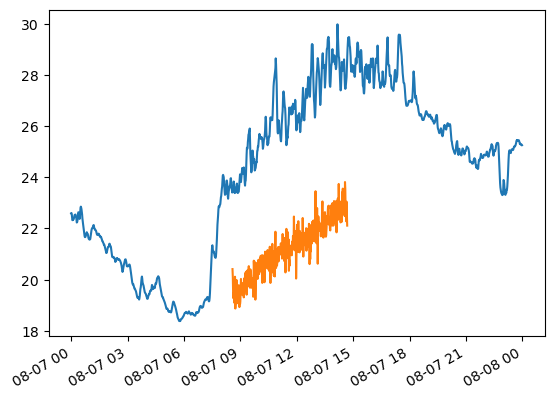

In [23]:
wbb = pd.read_csv(os.path.join(out_data_dir,'wbb_met.csv'),header=11)
wbb.index = pd.to_datetime(wbb['datetime_MDT'])
wbb_mini = wbb.loc[wbb.index.date==datetime.date(2023,8,7)]
plt.plot(wbb_mini['temp'])

dbk = pd.read_csv(os.path.join(out_data_dir,'dbk_met.csv'),header=11)
dbk.index = pd.to_datetime(dbk['datetime_MDT'])
dbk_mini = dbk.loc[dbk.index.date==datetime.date(2023,8,7)]
plt.plot(dbk_mini['temp'])
plt.gcf().autofmt_xdate()

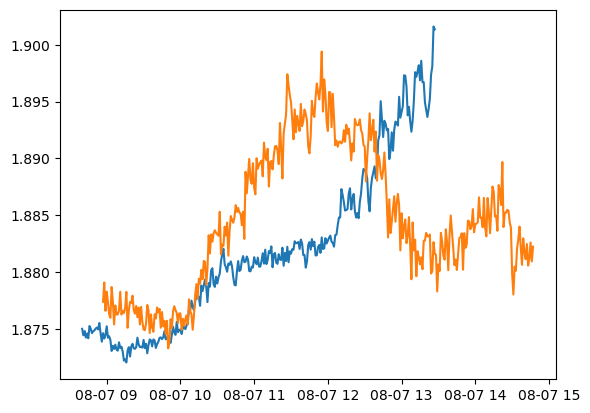

In [33]:
ua = pd.read_csv(os.path.join(out_data_dir,'ua.csv'),header = 22)
ua.index = pd.to_datetime(ua['datetime_MDT'])
ua_mini = ua.loc[ua.index.date==datetime.date(2023,8,7)]
plt.plot(ua_mini['corr_xch4(ppm)'])

ha = pd.read_csv(os.path.join(out_data_dir,'ha.csv'),header = 22)
ha.index = pd.to_datetime(ha['datetime_MDT'])
ha_mini = ha.loc[ha.index.date==datetime.date(2023,8,7)]
plt.plot(ha_mini['corr_xch4(ppm)'])